In [19]:
from distmesh import * 
import numpy as np 
import scipy as sc
from scipy.sparse import csr_matrix
from scipy.sparse import diags
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({
        "font.family": "Times", 
        "text.usetex": True,
        "font.size": 16
    })

count =  200 displacement =  0.012168586783411093
count =  400 displacement =  0.0034232089969463554
count =  600 displacement =  0.0037272056505444967
count =  800 displacement =  0.003385927624387421
count =  1000 displacement =  0.0026123859523727363
count =  1200 displacement =  0.0023135995093220927


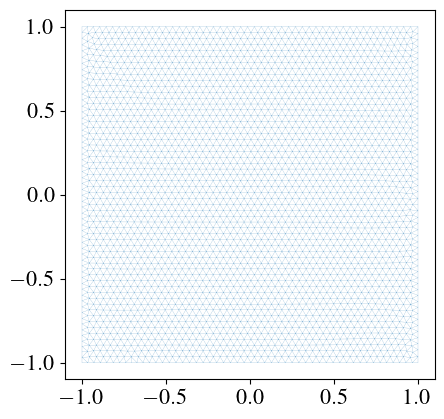

In [44]:
h = 0.04

pfix = np.array([[1,-1], [1,1], [-1,1], [-1,-1]])
bbox = np.array([-1,1,-1,1])

def fd(p):
    return drectangle(p,-1,1,-1,1)
pts, tri = distmesh2D(fd, huniform, h, bbox, pfix)

sc.io.savemat('mesh.mat', {'pts': pts, 'tri': tri})

In [43]:
npts, ntri = pts.shape[0], tri.shape[0]
tol = 1e-8
eps = 1e-2

# get Dirichlet BC 
dirichletBC = []
for k in range(npts): 
     x = pts[k,0]
     y = pts[k,1]
     if abs(x-1) <= tol or abs(y-1) <= tol or abs(x+1)<= tol or abs(y+1) <= tol:
          dirichletBC.append(k)
dirichletBC = np.array(dirichletBC)
def f(u): 
    return np.power(u, 3) - u
def localJ(vrts, u): 
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(vrts)
    rhs = np.zeros((3,2))
    rhs[1,0] = 1
    rhs[2,1] = 1
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    aux = np.matmul(eps*np.matmul(G, np.transpose(G)) - (1/12)*np.array([[2,1,1], [1,2,1], [1,1,2]]),u)
    btemp = aux + np.array([4 * u[0]**3 + u[1]**3 + u[2]**3 + 3 * u[0]**2 * (u[1] + u[2]) + 2 * u[0]\
                         * (u[1]**2 + u[2]**2) + u[1] * u[2] * (u[1] + u[2]) + 2 * u[0] * u[1] * u[2],\
                        4 * u[1]**3 + u[0]**3 + u[2]**3 + 3 * u[1]**2 * (u[0] + u[2]) + 2 * u[1]\
                         * (u[0]**2 + u[2]**2) + u[0] * u[2] * (u[0] + u[2]) + 2 * u[1] * u[0] * u[2],
                        4 * u[2]**3 + u[1]**3 + u[0]**3 + 3 * u[2]**2 * (u[1] + u[0]) + 2 * u[2]\
                         * (u[1]**2 + u[0]**2) + u[1] * u[0] * (u[1] + u[0]) + 2 * u[2] * u[1] * u[0]])/60
    return 0.5*np.linalg.det(Aux)*btemp
def localDJ(vrts, u): 
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(vrts)
    rhs = np.zeros((3,2))
    rhs[1,0] = 1
    rhs[2,1] = 1
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    aux = eps*np.matmul(G, np.transpose(G)) -(1/12)*np.array([[2,1,1], [1,2,1], [1,1,2]]) 
    M = aux + np.array([[12 * u[0]**2 + 2 * (u[1]**2 + u[2]**2 + u[1] * u[2]) + 6 * u[0] * (u[1] + u[2]), \
                         3 * (u[0]**2 + u[1]**2) + u[2]**2 + 4 * u[0] * u[1] + 2 * u[2] * (u[0] + u[1]), \
                         3 * (u[0]**2 + u[2]**2) + u[1]**2 + 4 * u[0] * u[2] + 2 * u[1] * (u[0] + u[2])],
                        [3 * (u[0]**2 + u[1]**2) + u[2]**2 + 4 * u[0] * u[1] + 2 * u[2] * (u[0] + u[1]), \
                         12 * u[1]**2 + 2 * (u[0]**2 + u[2]**2 + u[0] * u[2]) + 6 * u[1] * (u[0] + u[2]), \
                         3 * (u[1]**2 + u[2]**2) + u[0]**2 + 4 * u[1] * u[2] + 2 * u[0] * (u[1] + u[2])],
                        [3 * (u[0]**2 + u[2]**2) + u[1]**2 + 4 * u[0] * u[2] + 2 * u[1] * (u[0] + u[2]), \
                         3 * (u[1]**2 + u[2]**2) + u[0]**2 + 4 * u[1] * u[2] + 2 * u[0] * (u[1] + u[2]), \
                         12 * u[2]**2 + 2 * (u[0]**2 + u[1]**2 + u[0] * u[1]) + 6 * u[2] * (u[0] + u[1])]])/60
    return 0.5*np.linalg.det(Aux)*M
def uD(ind): 
     return np.zeros(ind.size)

freeNodes = np.setdiff1d(np.arange(npts), dirichletBC)
# initial condition 
u = -np.ones(npts)
u[dirichletBC] = uD(dirichletBC)
maxIters = 50
stopCriterion = 1e-10

for i in range(maxIters): 
    A = np.zeros((npts,npts))

    # assemble DJ
    for j in range(ntri): 
        triInd = tri[j,:]
        locDJ = localDJ(pts[triInd,:], u[triInd])
        A[triInd[:,None], triInd] = A[triInd[:,None], triInd] + locDJ[r,c]
        # for r in range(triInd.size):
        #     for c in range(triInd.size):
        #         A[triInd[r], triInd[c]] = A[triInd[r], triInd[c]] + 

    b = np.zeros(npts)
    # assemble J
    for j in range(ntri):
        triInd = tri[j,:]
        locJ = localJ(pts[triInd,:], u[triInd])
        b[triInd] = b[triInd] + locJ
    # Volume Forces
    for j in range(ntri): 
        triInd = tri[j,:]
        flocal = f(np.sum(u[triInd]/3))/6
        b[triInd] = b[triInd] + np.linalg.det(np.vstack((np.ones((1,3)), pts[triInd].T)))*flocal
    
    w = np.zeros(npts)
    ASparse = sc.sparse.csr_matrix(A[freeNodes[:,None], freeNodes])
    bSparse = sc.sparse.csr_matrix(b[freeNodes])
    wTemp = sc.sparse.linalg.spsolve(A[freeNodes[:,None], freeNodes], b[freeNodes])
    w[freeNodes] = wTemp
    u = u - w 
    norm = np.linalg.norm(w)
    if norm < stopCriterion:
        break
    


print()
          
# Newton-Raphson iteration 


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


KeyboardInterrupt: 